# Time Series Forecasting | Predicting Airline Passengers

<img src='https://dotdata.com/wp-content/uploads/2020/07/time-series.jpg' alt="Alt Text" style="height: 200px; width: 1000px;">

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [12]:
df['Date'] = pd.to_datetime('01-' + df['month'].astype(str) + '-' +df['year'].astype(str))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        144 non-null    int64         
 1   month       144 non-null    category      
 2   passengers  144 non-null    int64         
 3   Date        144 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(2)
memory usage: 4.0 KB


In [14]:
df.head()

,year,month,passengers,Date
0,1949,Jan,112,1949-01-01
1,1949,Feb,118,1949-02-01
2,1949,Mar,132,1949-03-01
3,1949,Apr,129,1949-04-01
4,1949,May,121,1949-05-01


In [15]:
df.set_index('Date', inplace = True)

In [16]:
df.head()

,year,month,passengers
Date,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


## How to Identify Stationary vs. Non-Stationary Data?
Here are three ways to check if your data is stationary:


### 1️⃣ Visual Inspection (Plot the Data)
* If the data has a trend (upward/downward movement) or seasonality (repeating patterns), it's likely non-stationary.

* If the data fluctuates around a constant mean, it’s likely stationary.

<Axes: xlabel='Date', ylabel='passengers'>

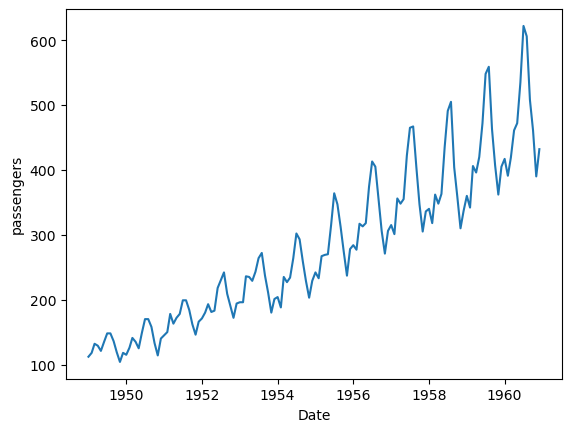

In [17]:
## let's create lineplot visualization
sns.lineplot(data = df, x= df.index, y = df.passengers)

## 2️⃣ Summary Statistics Check
* Divide the data into two equal parts.
* Compare the mean and variance of both halves.
* If they are significantly different, the data is non-stationary.

In [18]:
print("First Half Mean:", df['passengers'][:len(df)//2].mean())
print("Second Half Mean:", df['passengers'][len(df)//2:].mean())

print("First Half Variance:", df['passengers'][:len(df)//2].var())
print("Second Half Variance:", df['passengers'][len(df)//2:].var())


First Half Mean: 182.90277777777777
Second Half Mean: 377.69444444444446
First Half Variance: 2275.6946400625984
Second Half Variance: 7471.736306729265


## 3️⃣ Augmented Dickey-Fuller (ADF) Test
This is a statistical test that checks whether a time series is stationary.

* If the p-value < 0.05 → Stationary
* If the p-value > 0.05 → Non-Stationary (Needs Differencing)

In [19]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['passengers'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The data is stationary (Reject H0).")
else:
    print("The data is non-stationary (Fail to reject H0).")


ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641
The data is non-stationary (Fail to reject H0).


## How to Make Non-Stationary Data Stationary?
As the data is non-stationary, we need to transform it into a stationary series before applying forecasting models like ARIMA. Here are some common techniques to make non-stationary data stationary

### 1️⃣  Shift Time Method: 
Subtracts the value of a previous season from the current value.

In [20]:
air_df = df[['passengers']]
air_df.head()

,passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [21]:
air_df['shift1'] = air_df['passengers'].shift(1)
air_df['shiftDiff'] = air_df['passengers'] - air_df['shift1']
air_df.head()

C:\Users\rm217\AppData\Local\Temp\ipykernel_17628\3547432209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_df['shift1'] = air_df['passengers'].shift(1)


,passengers,shift1,shiftDiff
Date,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,112.0,6.0
1949-03-01,132,118.0,14.0
1949-04-01,129,132.0,-3.0
1949-05-01,121,129.0,-8.0


### Checking if Data is Stationary using ADF test

In [22]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(air_df['shiftDiff'].dropna())  # Use transformed column
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The data is stationary ✅")
else:
    print("The data is still non-stationary ❌")


ADF Statistic: -2.8292668241699923
p-value: 0.054213290283826474
The data is still non-stationary ❌


## 2️⃣ Now Let's try with Log Transformation Method
Reduces large variations in data by compressing high values.



In [23]:
log_df = df[['passengers']]
log_df['log'] = np.log(log_df['passengers'])
log_df.head()

C:\Users\rm217\AppData\Local\Temp\ipykernel_17628\3829350932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df['log'] = np.log(log_df['passengers'])


,passengers,log
Date,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


### Checking if Data is Stationary using ADF test

In [24]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(log_df['log'].dropna())  # Use transformed column
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The data is stationary ✅")
else:
    print("The data is still non-stationary ❌")


ADF Statistic: -1.717017089106963
p-value: 0.4223667747703902
The data is still non-stationary ❌


## 3️⃣ Now let's try with Square Root Method
Stabilizes variance like log transformation but works on negative values too.

In [25]:
sqrt_df = df[['passengers']]
sqrt_df['sqrt'] = np.sqrt(df['passengers'])
sqrt_df.head()

C:\Users\rm217\AppData\Local\Temp\ipykernel_17628\2486983579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sqrt_df['sqrt'] = np.sqrt(df['passengers'])


,passengers,sqrt
Date,,
1949-01-01,112,10.583005
1949-02-01,118,10.862780
1949-03-01,132,11.489125
1949-04-01,129,11.357817
1949-05-01,121,11.000000


### Checking if Data is Stationary using ADF test

In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sqrt_df['sqrt'].dropna())  # Use transformed column
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The data is stationary ✅")
else:
    print("The data is still non-stationary ❌")

ADF Statistic: -0.345853767715672
p-value: 0.9187543217618374
The data is still non-stationary ❌


## 4️⃣ Now let's try the combination of all three methods together


In [27]:
log_df2 = log_df[['passengers', 'log']]
log_df2['log_sqrt'] = np.sqrt(log_df['log'])
log_df2['logShiftDiff'] = log_df2['log_sqrt'] - log_df2['log_sqrt'].shift(1)
log_df2.head()

,passengers,log,log_sqrt,logShiftDiff
Date,,,,
1949-01-01,112,4.718499,2.172211,NaN
1949-02-01,118,4.770685,2.184190,0.011979
1949-03-01,132,4.882802,2.209706,0.025517
1949-04-01,129,4.859812,2.204498,-0.005208
1949-05-01,121,4.795791,2.189929,-0.014569


In [28]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(log_df2['logShiftDiff'].dropna())  # Use transformed column
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The data is stationary ✅")
else:
    print("The data is still non-stationary ❌")

ADF Statistic: -2.611019286583825
p-value: 0.09074112486704233
The data is still non-stationary ❌


# Next Step 

In [29]:
## Let's create a subset of dataset 
dff = df[['passengers']]
dff.head()

,passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [30]:
## Let's create two more variable two reduce the seasonality
dff['Diff1'] = dff['passengers'].diff()
dff['Diff12'] = dff['passengers'].diff(12)   #As there was seasonality of 12 months
dff.head()

C:\Users\rm217\AppData\Local\Temp\ipykernel_17628\3512555843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Diff1'] = dff['passengers'].diff()


,passengers,Diff1,Diff12
Date,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,NaN
1949-04-01,129,-3.0,NaN
1949-05-01,121,-8.0,NaN


# Step 4: Determine ARIMA Parameters (p, d, q)


* 1. p (AutoRegressive - AR term) - It represents the number of past values (lags) used to predict future values.
* 2. d (Differencing - I term) - It represents the number of times the data is differenced to make it stationary.
* 3. q (Moving Average - MA term) - It represents the number of past error terms (residuals) used to predict future values.


In [31]:
## Importing important libraries

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 1. Find d (Differencing Order)

* d is simply the differencing value (lag value) that we used for ADF test so d = 1

### 2. Find p (AR Order) using PACF
Once data is stationary, p is determined using the Partial Autocorrelation Function (PACF) plot.


C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


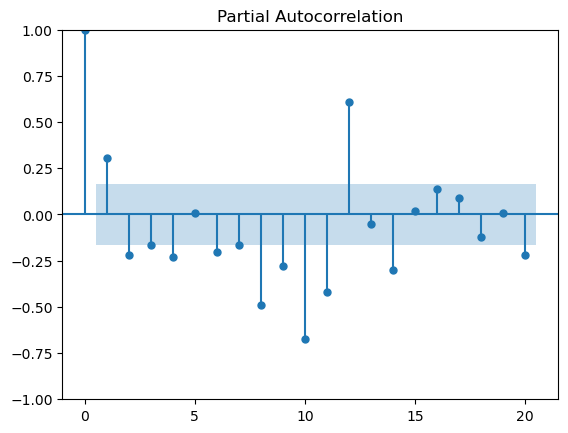

In [32]:
plot_pacf(dff['Diff1'].dropna(), lags=20)
plt.show()

### 3. Find q (MA Order) using ACF
The q value is determined using the AutoCorrelation Function (ACF) plot.


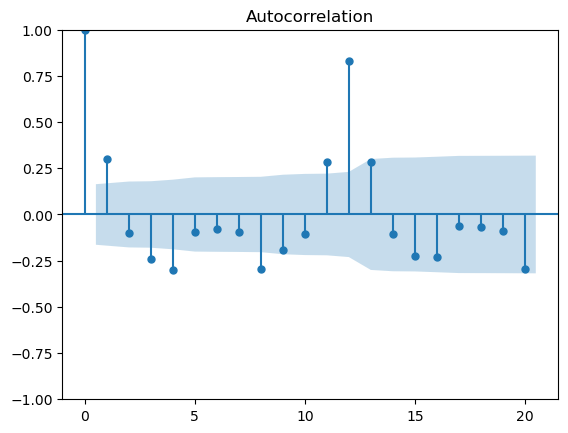

In [33]:
plot_acf(dff['Diff1'].dropna(), lags=20)
plt.show()

### Split the Data (70% Training, 30% Testing)


In [34]:
train = dff[:round(len(dff)*0.7)]
test = dff[round(len(dff)*0.7):]
test.head()

,passengers,Diff1,Diff12
Date,,,
1957-06-01,422,67.0,48.0
1957-07-01,465,43.0,52.0
1957-08-01,467,2.0,62.0
1957-09-01,404,-63.0,49.0
1957-10-01,347,-57.0,41.0


### Train the ARIMA Model on Training Data & Make Predictions on the Test Data

In [35]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model using training data
model = ARIMA(train['passengers'], order=(1,1,3))  # (p=1, d=1, q=3)
model_fit = model.fit()

# Prection on Test Data
prediction = model_fit.predict(start = test.index[0], end = test.index[-1])

# Creating new column for predicion value
dff['arimaPred'] = prediction

# To show the data
dff.tail()

C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,passengers,Diff1,Diff12,arimaPred
Date,,,,
1960-08-01,606,-16.0,47.0,341.111333
1960-09-01,508,-98.0,45.0,341.111333
1960-10-01,461,-47.0,54.0,341.111333
1960-11-01,390,-71.0,28.0,341.111333
1960-12-01,432,42.0,27.0,341.111333


### Visualize the Actual vs. Predicted Values

<Axes: xlabel='Date', ylabel='passengers'>

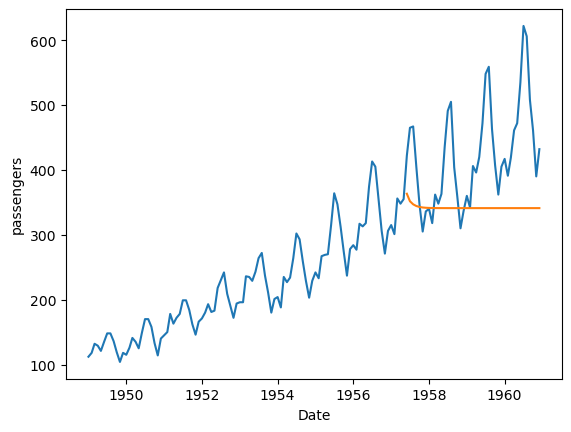

In [36]:
dff.dropna()
sns.lineplot(data = dff, x = dff.index, y = dff['passengers'])
sns.lineplot(data = dff, x = dff.index, y = dff['arimaPred'])


### Evaluate Model Performance (MSE, RMSE, MAE)
To measure how well the model performed, calculate Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and RMSE
mse = mean_squared_error(test['passengers'], prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['passengers'], prediction)

print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('Mean Absolute Error (MAE): ', mae)


Mean Squared Error (MSE):  12345.455074143723
Root Mean Squared Error (RMSE):  111.11010338463251
Mean Absolute Error (MAE):  85.2024011089832


### Find p, and q for SARIMA Model

C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


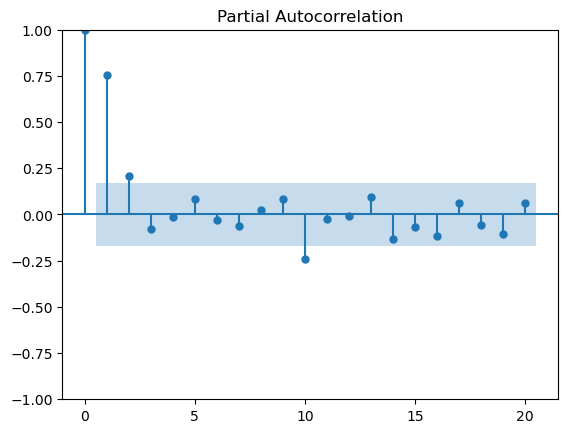

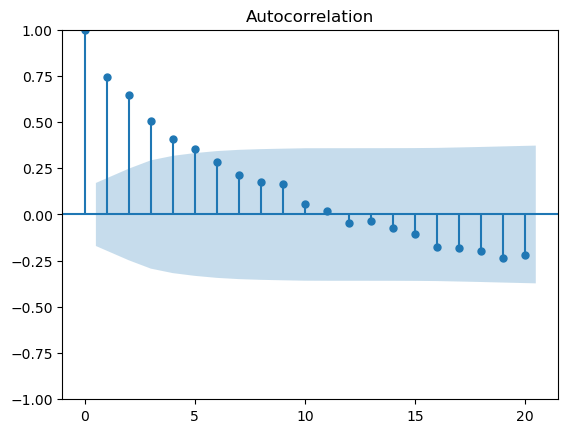

In [38]:
# for p
plot_pacf(dff['Diff12'].dropna(), lags=20)
plt.show()

# for q
plot_acf(dff['Diff12'].dropna(), lags=20)
plt.show()

### Fit SARIMA Model

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model
sarima_model = SARIMAX(train['passengers'], 
                       order=(1,1,3),  # ARIMA (p,d,q)
                       seasonal_order=(2,1,2,12))  # Seasonal (P,D,Q,s)

# Fit the model
model_fit = sarima_model.fit()

# Prection on Test Data
prediction = model_fit.predict(start = test.index[0], end = test.index[-1])

# Creating new column for predicion value
dff['sarimaPred'] = prediction

# To show the data
dff.tail()

C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\rm217\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likel

,passengers,Diff1,Diff12,arimaPred,sarimaPred
Date,,,,,
1960-08-01,606,-16.0,47.0,341.111333,598.413340
1960-09-01,508,-98.0,45.0,341.111333,534.029299
1960-10-01,461,-47.0,54.0,341.111333,478.823230
1960-11-01,390,-71.0,28.0,341.111333,431.467394
1960-12-01,432,42.0,27.0,341.111333,476.839415


### Visualize the Actual vs. Predicted Values with SARIMA 

<Axes: xlabel='Date', ylabel='passengers'>

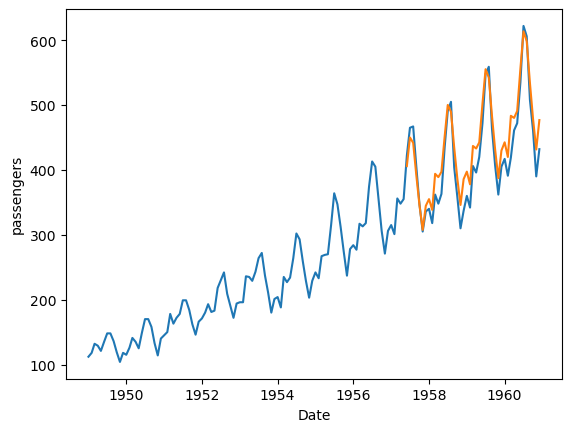

In [40]:
dff.dropna()
sns.lineplot(data = dff, x = dff.index, y = dff['passengers'])
sns.lineplot(data = dff, x = dff.index, y = dff['sarimaPred'])

### Evaluate SARIMA Model
Check errors just like ARIMA:

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and RMSE
mse = mean_squared_error(test['passengers'], prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['passengers'], prediction)

print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('Mean Absolute Error (MAE): ', mae)


Mean Squared Error (MSE):  756.3497720274069
Root Mean Squared Error (RMSE):  27.50181397703444
Mean Absolute Error (MAE):  24.30414264868377


##  Forecast Future Values

In [42]:
## Check the last date
dff.tail()

,passengers,Diff1,Diff12,arimaPred,sarimaPred
Date,,,,,
1960-08-01,606,-16.0,47.0,341.111333,598.413340
1960-09-01,508,-98.0,45.0,341.111333,534.029299
1960-10-01,461,-47.0,54.0,341.111333,478.823230
1960-11-01,390,-71.0,28.0,341.111333,431.467394
1960-12-01,432,42.0,27.0,341.111333,476.839415


### Create a dataframe for future dates

In [43]:
# Create DataFrame with Date Range
futureDate = pd.DataFrame({'Dates': pd.date_range(start='1961-01-01', end='1962-12-01', freq='MS')})
futureDate.set_index('Dates', inplace = True)
futureDate.head()

""
Dates
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01


## Predicting values for future dates

In [44]:
future_prediction = model_fit.predict(start = futureDate.index[0], end = futureDate.index[-1])
future_prediction.head()

1961-01-01    490.668953
1961-02-01    465.159807
1961-03-01    532.965630
1961-04-01    530.209548
1961-05-01    542.083695
Freq: MS, Name: predicted_mean, dtype: float64

## Visualize the Forecast

<Axes: xlabel='Date', ylabel='passengers'>

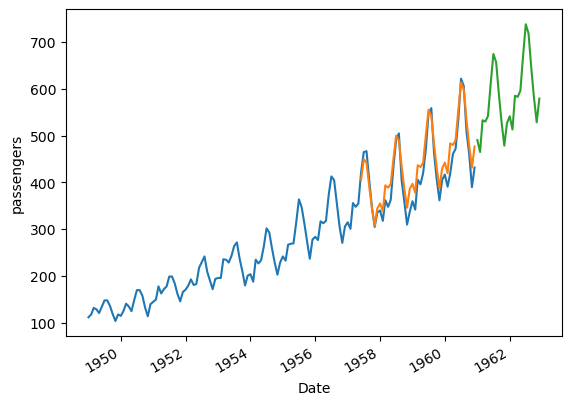

In [45]:
dff.dropna()
sns.lineplot(data = dff, x = dff.index, y = dff['passengers'])  #Actual data
sns.lineplot(data = dff, x = dff.index, y = dff['sarimaPred'])  #Prediction on test data
future_prediction.plot()                               #Prediction on future

### Adding the data labels

<Axes: xlabel='Date', ylabel='passengers'>

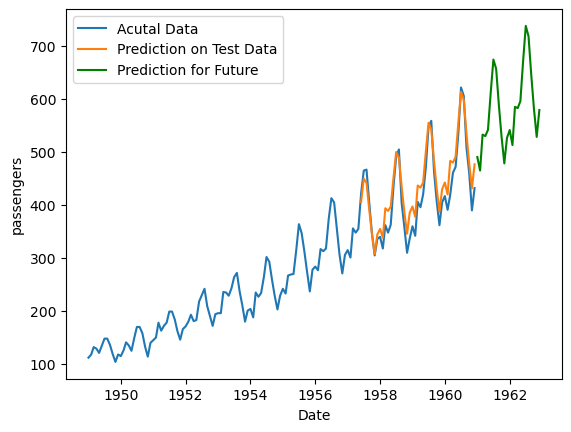

In [46]:
dff.dropna()
sns.lineplot(data = dff, x = dff.index, y = dff['passengers'], label = 'Acutal Data')  #Actual data
sns.lineplot(data = dff, x = dff.index, y = dff['sarimaPred'], label = 'Prediction on Test Data')  #Prediction on test data
sns.lineplot(x=futureDate.index, y=future_prediction, label='Prediction for Future', color='green')  #Prediction on future